# WAMM Sensitivity Analysis

**What does this notebook do?** 
This notebook tests the impact of using different time range and wetness thresholds on the number, size, and spatial distribution of identified water bodies. This notebook assists in the selection of appropriate thresholds by exploring the impact of different values on the overall results. 

There are two parameters that are explored here:
- time ranges
- wetness threshold

**Time range** refers to the length of time over which the water classified summary statistics are calculated. The water classifier used here is the [Water Observations from Space (WOfS)](https://www.sciencedirect.com/science/article/pii/S0034425715301929) decision tree algorithm. 

The summary statistics were generated using the [datacube-stats](https://github.com/opendatacube/datacube-stats) package, which is a tool for generating large-scale temporal statistics on data within Digital Earth Australia. This package was used to calculate frequency counts and statistics for 

Time ranges tested:
- Jan 1990 to Dec 2018
- Jan 1995 to Dec 2018
- Jan 2000 to Dec 2018
- Jan 2005 to Dec 2018
- Jan 2010 to Dec 2018
- Jan 2015 to Dec 2018

AtLeastThisWet thresholds tested:
- 20%
- 10%
- 5%
- 2%
- 1% - this test was not completed for 2015-2018 as the number of polygons was too high. This threshold is far too sensitive.

**Required inputs:** 

**Optional inputs**

**Code history**

This notebook is an ammended copy of `GenerateWaterBodyPolygons.ipynb`. 

**Date:** April 2019

**Author:** Claire Krause

In [ ]:
%pylab notebook

import rasterio.features
from shapely.geometry import Polygon, shape, mapping
from shapely.ops import unary_union
import geopandas as gp
import fiona
from fiona.crs import from_epsg
import xarray as xr
import pandas as pd
import glob
import os.path
import math
import seaborn

## Set up the functions for this script

In [ ]:
def Generate_list_of_albers_tiles(TileFolder = 'TileFolder'):
    '''
    Generate a list of Albers tiles to loop through for the water body analysis. This 
    function assumes that the list of tiles will be generated from a custom 
    datacube-stats run, and the file names will have the format
    
    */wofs_summary_8_-37_{date}.nc
    
    The tile number is expected in the 2nd and 3rd last positions when the string has been
    broken using `_`. If this is not the case, then this code will not work, and will throw an error. 
    
    Parameters
    ----------
    
    TileFolder : str
        This is the path to the folder of netCDF files for analysis. If this is not provided, or an
        incorrect path name is provided, the code will exit with an error.
    
    Returns
    -------
    CustomRegionAlbersTiles: list
        List of Albers tiles across the analysis region. 
        E.g. ['8_-32', '9_-32', '10_-32', '8_-33', '9_-33']
    
    '''  
    if os.path.exists(TileFolder) == False:
        print('** ERROR ** \n'
            'You need to specify a folder of files for running a custom region')
        return
    
    # Grab a list of all of the netCDF files in the custom folder
    TileFiles = glob.glob(f'{TileFolder}*.nc')

    CustomRegionAlbersTiles = set()
    for filePath in TileFiles:
        AlbersTiles = filePath.split('_')
        
        # Test that the albers tile numbers are actually where we expect them to be in the file name
        try: 
            int(AlbersTiles[-3])
            int(AlbersTiles[-2])
        except ValueError:
            print('** ERROR ** \n'
                'The netCDF files are expected to have the file format "*/wofs_summary_8_-37_{date}.nc",\n'
                'with the Albers tile numbers in the 2nd and 3rd last positions when separated on `_`. \n'
                'Please fix the file names, or alter the `Generate_list_of_albers_tiles` function.')
            return

        # Now that we're happy that the file is reading the correct Albers tiles
        ThisTile = f'{AlbersTiles[-3]}_{AlbersTiles[-2]}'
        CustomRegionAlbersTiles.add(ThisTile)
    CustomRegionAlbersTiles = list(CustomRegionAlbersTiles)
    return CustomRegionAlbersTiles

def Generate_list_of_tile_datasets(ListofAlbersTiles, Year, TileFolder = 'TileFolder'):
    '''
    Generate a list of Albers tiles datasets to loop through for the water body analysis. 
    
    Parameters
    ----------
    
    CustomRegionAlbersTiles: list
        List of albers tiles to loop through
        E.g. ['8_-32', '9_-32', '10_-32', '8_-33', '9_-33']
    Year: int
        Year for the analysis. This will correspond to the netCDF files for analysis.
    TileFolder : str
        This is the path to the folder of netCDF files for analysis. If this is not provided, or an
        incorrect path name is provided, the code will exit with an error.
    
    Returns
    -------
    Alltilespaths: list
        List of file paths to files to be analysed.
    
    '''  
    
    if os.path.exists(TileFolder) == False:
        print('** ERROR ** \n'
            'You need to specify a folder of files for running a custom region')
        raise

    Alltilespaths = []
    
    for tile in ListofAlbersTiles:
        Tiles = glob.glob(f'{TileFolder}*_{tile}_{Year}0101.nc')
        Alltilespaths.append(Tiles[0]) # Assumes only one file will be returned
 
    return Alltilespaths

def Filter_shapefile_by_intersection(gpdData, gpdFilter, filtertype = 'intersects', invertMask = True, 
                                     returnInverse = False):
    '''
    Filter out polygons that intersect with another polygon shapefile. 
    
    Parameters
    ----------
    
    gpdData: geopandas dataframe
        Polygon data that you wish to filter
    gpdFilter: geopandas dataframe
        Dataset you are using as a filter
    
    Optional
    --------
    filtertype: default = 'intersects'
        Options = ['intersects', 'contains', 'within']
    invertMask: boolean
        Default = 'True'. This determines whether you want areas that DO ( = 'False') or DON'T ( = 'True')
        intersect with the filter shapefile.
    returnInnverse: boolean
        Default = 'False'. If true, then return both parts of the intersection - those that intersect AND 
        those that don't as two dataframes.
    
    Returns
    -------
    gpdDataFiltered: geopandas dataframe
        Filtered polygon set, with polygons that intersect with gpdFilter removed.
    
    Optional
    --------
    if 'returnInverse = True'
    gpdDataFiltered, gpdDataInverse: two geopandas dataframes
        Filtered polygon set, with polygons that DON'T intersect with gpdFilter removed.
    '''    
    
    # Check that the coordinate reference systems of both dataframes are the same
    
    assert gpdData.crs == gpdFilter.crs, 'Make sure the the coordinate reference systems of the two provided dataframes are the same'
    
    Intersections = gp.sjoin(gpdFilter, gpdData, how="inner", op=filtertype)
    
    # Find the index of all the polygons that intersect with a river
    IntersectIndex = sorted(set(Intersections['index_right']))
    
    # Grab only the polygons NOT in the IntersectIndex
    # i.e. that don't intersect with a river
    if invertMask:
        gpdDataFiltered = gpdData.loc[~gpdData.index.isin(IntersectIndex)]
    else:
        gpdDataFiltered = gpdData.loc[gpdData.index.isin(IntersectIndex)]
    
    if returnInverse:
        # We need to use the indices from IntersectIndex to find the inverse dataset, so we
        # will just swap the '~'.
        
        if invertMask:
            gpdDataInverse = gpdData.loc[gpdData.index.isin(IntersectIndex)]
        else:
            gpdDataInverse = gpdData.loc[~gpdData.index.isin(IntersectIndex)]
            
        return gpdDataFiltered, gpdDataInverse
    else:    
        
        return gpdDataFiltered

## Set up all the parameters for the script

### Filter results based on number of valid observations

In [ ]:
MinimumValidObs = 76

In [ ]:
MinSize = 3120 # 5 pixels
MaxSize = math.inf # No upper limit

## Threshold for wetness
This variable was varied to test the sensitivity of this parameter on the overall results:
- 0.2
- 0.1
- 0.05
- 0.02
- 0.01

In [ ]:
AtLeastThisWet = 0.01

<a id='Tiles'></a>
### Is this analysis for all of Australia, or just a subset?

In [ ]:
CustomRegion = True
ListofAlbersTiles = Generate_list_of_albers_tiles(TileFolder)

<a id='Urban'></a>

### Read in a mask for high-rise CBDs

In [ ]:
UrbanMaskFile = '/g/data/r78/cek156/ShapeFiles/ABS_1270055001_sa3_2016_aust_shape/HighRiseCBD_ABS_sa3.shp'

CBDs = gp.read_file(UrbanMaskFile)
CBDs = CBDs.to_crs({'init': 'epsg:3577'})

## Loop through each tile and polygonise the annual WOfS data

In [ ]:
# Does the analysis a year at a time. If there is a singple year only, set the year range to be 
# `range(year, year + 1)`

for year in range(1990,20016,5):
    
    ### Set up some file names for the inputs and outputs

    # The name and filepath of the intermediate output polygon set
    WaterBodiesShp = f'/g/data/r78/cek156/dea-notebooks/Dams/WAMMSensitivity/WaterBodies{year}_{AtLeastThisWet}.shp'

    ### Get the list of netcdf file names to loop through
    if CustomRegion:
        # Grab the file names from the custom folder we specified
        Alltiles = Generate_list_of_tile_datasets(ListofAlbersTiles, year, TileFolder)
    else:
        # Grab the all time summaries
        # Note that the location of these files must be set with the `TileFolder` parameter above
        Alltiles = glob.glob(f'{TileFolder}*_{year}_summary.nc')
        
    for WOFSfile in Alltiles: 
        # Read in the data
        # Note that the netCDF files we are using here contain a variable called 'frequency',
        # which is what we are using to define our water polygons.
        # If you use a different netCDF input source, you may need to change this variable name here
        WOFSnetCDFData = xr.open_rasterio(f'NETCDF:{WOFSfile}:frequency')
        # Remove the superfluous time dimension
        WOFSnetCDFData = WOFSnetCDFData.squeeze()

        # Open the clear count variable to generate the minimum observation mask
        WOFSvalidcount = xr.open_rasterio(f'NETCDF:{WOFSfile}:count_clear')
        WOFSvalidcount = WOFSvalidcount.squeeze()

        # Filter our WOfS classified data layer to remove noise
        # Remove any pixels not abserved at least MinimumValidObs times
        WOFSValidFiltered = WOFSvalidcount >= MinimumValidObs

        # Remove any pixels that are wet < AtLeastThisWet% of the time
        WOFSfiltered = WOFSnetCDFData > AtLeastThisWet

        # Now find pixels that meet both the MinimumValidObs and AtLeastThisWet criteria
        # Change all zeros to NaN to create a nan/1 mask layer
        # Pixels == 1 now represent our water bodies
        WOFSfiltered = WOFSfiltered.where((WOFSfiltered !=0) & (WOFSValidFiltered !=0))

        # Convert the raster to polygons
        # We use a mask of '1' to only generate polygons around values of '1' (not NaNs)
        WOFSpolygons = rasterio.features.shapes(WOFSfiltered.data.astype('float32'), 
                                                mask = WOFSfiltered.data.astype('float32') == 1,
                                                transform = WOFSnetCDFData.transform)
        # The rasterio.features.shapes returns a tuple. We only want to keep the geometry portion,
        # not the value of each polygon (which here is just 1 for everything)
        WOFSbreaktuple = (a for a, b in WOFSpolygons)

        # Put our polygons into a geopandas geodataframe
        PolygonGP = gp.GeoDataFrame(list(WOFSbreaktuple))

        # Grab the geometries and convert into a shapely geometry
        # so we can quickly calcuate the area of each polygon
        PolygonGP['geometry'] = None
        for ix, poly in PolygonGP.iterrows():
            poly['geometry'] = shape(poly)

        # Set the geometry of the dataframe to be the shapely geometry we just created    
        PolygonGP = PolygonGP.set_geometry('geometry')
        # We need to add the crs back onto the dataframe
        PolygonGP.crs = {'init': 'epsg:3577'}

        # Combine any overlapping polygons
        MergedPolygonsGeoms = unary_union(PolygonGP['geometry'])

        # Turn the combined multipolygon back into a geodataframe
        MergedPolygonsGPD = gp.GeoDataFrame([poly for poly in MergedPolygonsGeoms])
        # Rename the geometry column
        MergedPolygonsGPD.columns = ['geometry']
        # We need to add the crs back onto the dataframe
        MergedPolygonsGPD.crs = {'init': 'epsg:3577'}

        # Calculate the area of each polygon again now that overlapping polygons
        # have been merged
        MergedPolygonsGPD['area'] = MergedPolygonsGPD['geometry'].area

        # Filter out any polygons smaller than MinSize, and greater than MaxSize
        WaterBodiesBig = MergedPolygonsGPD.loc[((MergedPolygonsGPD['area'] > MinSize) & 
                                          (MergedPolygonsGPD['area'] <= MaxSize))]

        # WOfS has a known bug where deep shadows from high-rise CBD buildings are misclassified
        # as water. We will use the ABS sa3 dataset to filter out Brisbane, Gold Coast, Sydney, 
        # Melbourne, Adelaide and Perth CBDs. 
        NotCities = Filter_shapefile_by_intersection(WaterBodiesBig, CBDs)

        # Save the polygons to a shapefile
        schema = {'geometry': 'Polygon','properties': {'area': 'str'}}

        if os.path.isfile(WaterBodiesShp):
            with fiona.open(WaterBodiesShp, "a", crs = from_epsg(3577), 
                            driver = 'ESRI Shapefile', schema = schema) as output:
                for ix, poly in NotCities.iterrows():
                                output.write(({'properties': {'area': poly['area']},
                                               'geometry': mapping(shape(poly['geometry']))})) 
        else:
            with fiona.open(WaterBodiesShp, "w", crs = from_epsg(3577), 
                            driver = 'ESRI Shapefile', schema = schema) as output:
                for ix, poly in NotCities.iterrows():
                    output.write(({'properties': {'area': poly['area']},
                                   'geometry': mapping(shape(poly['geometry']))}))

# Results

In [3]:
# Create a list of all of the sensitivity test shapefiles
AllSensitivityResults = glob.glob(f'/g/data/r78/cek156/dea-notebooks/Dams/WAMMSensitivity/WaterBodies*.shp')

## Exploring the effect of time range on results

Here we use the total area inside all identified polygons as a means to assess the relative impact of time range and threshold on the results. 

<IPython.core.display.Javascript object>


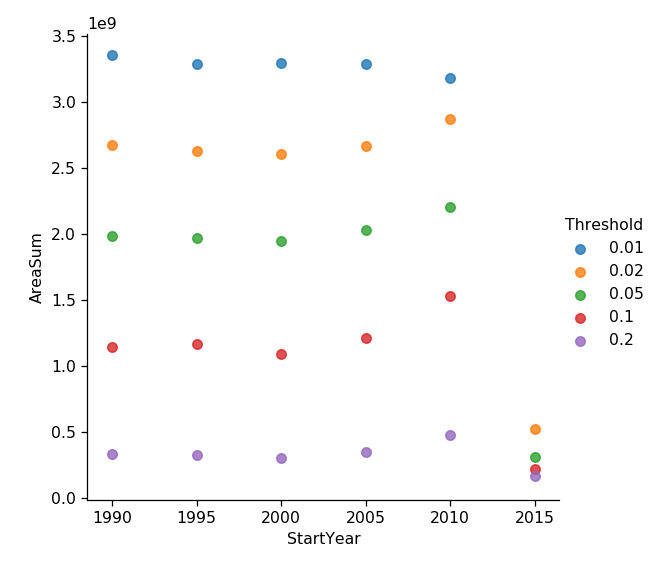

In [4]:
AreaData = []

for File in AllSensitivityResults:
    PolygonShapes = gp.read_file(File)
    AllPolygonArea = PolygonShapes.area.sum()
    # Break up the file name to get the start year, and threshold
    GDataBit, ThresholdBit = File.split('_')
    StartYear = GDataBit[-4:]
    Threshold = ThresholdBit[:-4]
    AreaData.append([AllPolygonArea, StartYear, Threshold])

AreaDataFrame = pd.DataFrame(AreaData, columns=['AreaSum', 'StartYear', 'Threshold'])
AreaDataFrame['StartYear'] = pd.to_numeric(AreaDataFrame['StartYear'])

seaborn.lmplot(x='StartYear', y='AreaSum', data = AreaDataFrame, fit_reg = False, hue = 'Threshold')

**From the figure above we can conclude that the number of years over which the results are integrated doesn't have a large affect on the overall results, with the exception of the 2015-2018 analysis.** 

We can see that the sensitivity of the results from the 2015-2018 analysis is far too low, and many of the polygon pixels picked up in the other analyses are missed over this short integration period. 

There is a slight increase in the area of wet pixels identified for the 2010-2018 analysis period, likely due to the strong La Nina event seen in 2010/11, which would result in a more frequent wet observation (wet/total observations), and therefore increased likelihood of inclusion in the results. 

### Given the relative similarities between the longer time integrated analysis periods, we will select the period 2000-2018 as the period over which to integrate the wet observations, for the following reasons:
- This analysis involves less data than a full temporal integration (1987-2018), with little discernible impact on the results, and so minimises compute required
- Focusing the analysis on more recent years increases the likelihood of newly created waterbodies to be identified. Newer waterbodies will have fewer total wet observations. Performing the analysis over a shorter time period means that when the total number of wet observations are divided by the total number of clear observations (to produce frequency statistics), the frequency of wet observations will be higher, and therefore, the waterbody is more likely to be included in the final results. 

## Exploring the effect of different thresholds on the overall results

Here we explore the effect of difference wetness thresholds on the total area inside all identified polygons for each sensitivity test combination.

<IPython.core.display.Javascript object>


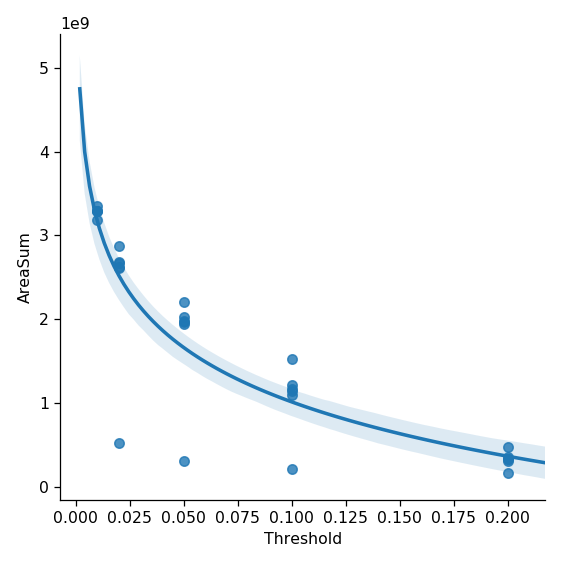

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


In [5]:
AreaDataFrame['Threshold'] = pd.to_numeric(AreaDataFrame['Threshold'])
seaborn.lmplot(x='Threshold', y='AreaSum', data = AreaDataFrame, logx = True)

**Overall, we can see that the total area of identified polygons increases as the threshold applied reduces.**

The outliers seen on this plot represent the data for the 2015-2018 period, where the total polygon area is underestimated.

It is unclear from this plot whether the increase in total polygon area is related to the identification of more polygons, or simply increases in the relative size of individual polygons. 

## Impact of wetness threshold on polygon number and size

Here we explore both the number and size of polygons identified using each of the tested thresholds. We perform this analysis only for the 2000-2018 results, as these have been identified as the preferred time range in the analysis above. 

<IPython.core.display.Javascript object>


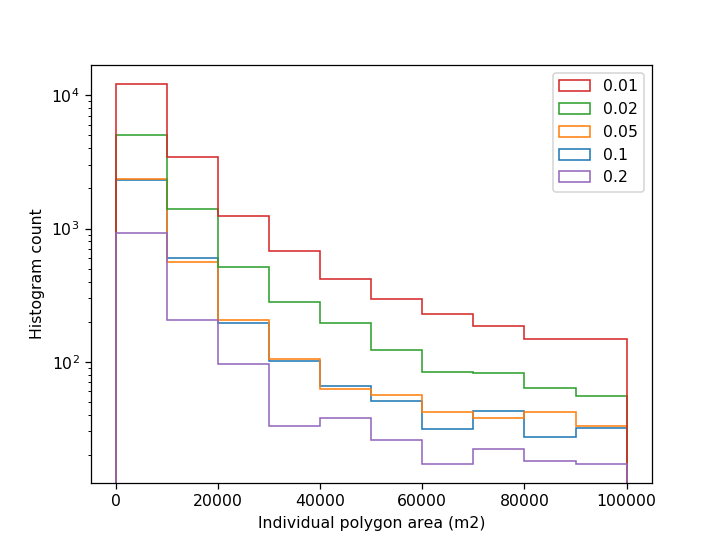

Text(0, 0.5, 'Histogram count')

In [29]:
fig, ax = plt.subplots()
for File in AllSensitivityResults:
    GDataBit, ThresholdBit = File.split('_')
    StartYear = GDataBit[-4:]
    Threshold = ThresholdBit[:-4]
    
    # Only perform the analysis on results for 2000-2018
    if StartYear == '2000':
        PolygonShapes = gp.read_file(File)
        PolygonShapes['area'] = pd.to_numeric(PolygonShapes['area'])

        plt.hist(PolygonShapes['area'], bins = list(range(0, 110000, 10000)), 
                 label=Threshold, histtype = 'step')
    else:
        continue

handles, labels = ax.get_legend_handles_labels()
handles, labels = zip(*[ (handles[i], labels[i]) 
                        for i in sorted(range(len(handles)), 
                                        key=lambda k: list(map(float,labels))[k])] )
        
plt.legend(handles, labels)
plt.yscale('log')
plt.xlabel('Individual polygon area (m2)')
plt.ylabel('Histogram count')

From the above plot, we can draw the following conclusions:
- At the lowest and second lowest thresholds (0.01 and 0.02), polygons increase in both total number, and relative size
- Results for the 0.05 and 0.1 thresholds give quite similar overall results
- A threshold of 0.2 results in fewer total polygons at all sizes

## Are more (and larger) polygons better?

An assessment as to the most appropriate final threshold to use will need to be somewhat subjective. While we can quantify the different affects caused by varying the time period and wetness threshold, a judgement call as to an acceptable signal:noise ratio will need to be made. 

Here we provide the evidence used to come to the final decision.

![All thresholds](AllThresholds.JPG "All thresholds shown, with darker blues = higher thresholds, and lighter blues for lower thresholds")

In the above image, all of the thresholds (all run over 2000-2018) have been added to the map. The darkest blue represents the 0.01 threshold, with the lightest blue being 0.2.

As you can see, the lowest threshold of 0.01, shown in the darkest blue, returns a lot of noise. There is some clear striping from Landsat 7's scan line corrector failure, as well as a lot of small polygons that do not clearly line up with waterbody features. 

**We therefore discount 0.01 (i.e. 1%) as an acceptable wetness threshold.**

![Remove 0.01](No0.01.JPG "All thresholds shown, with darker blues = higher thresholds, and lighter blues for lower thresholds")

With the 0.01 threshold removed, it is clear that most of the noisy polygons have also been removed. There still remains a reasonable number of small, noisy pixels that appear to be associated with intermittently wet features (like soggy bits in paddocks), rather than water bodies. 

**We therefore discount 0.02 (i.e. 2%) as an acceptable wetness threshold**

![Remove 0.02](No0.02.JPG "All thresholds shown, with darker blues = higher thresholds, and lighter blues for lower thresholds")

On the left hand side of the image above (and in other areas not shown), we can see that the threshold of 0.2 misses parts of water bodies (as seen by the smaller polygons sitting inside of the larger ones), resulting in only portions of waterbodies being mapped. It also misses entire waterbodies, which are observed as wet less frequently.

**The sensitivity of the 0.2 (20%) wetness threshold is too conservative, so we therefore discount it as an acceptable wetness threshold.**

Determining the most suitable threshold between the two remaining thresholds (0.1 and 0.05) is difficult. We can see from above, there is little difference between both the total number of water bodies, and the relative size of individual polygons, however spatially, the two threshold can be seen to have quite different results. 

To make the differences between the two thresholds easier to visualise, we have recoloured the polygons:
- 0.1 = purple
- 0.05 = yellow

![Agricultural Comparison](AgricultureArea.JPG "0.1 Threshold = purple, 0.05 threshold = yellow")

In the area above, (northern NSW), we can see that the lower threshold of 0.05 (shown in yellow) appears to do a better job of characterising waterbodies. The Purple polygons frequently pick up only parts of waterbodies, whereas the yellow polygons pick up the whole waterbody area, as well as some additional smaller waterbodies. 

![Lake Frome Comparison](LakeFrome.JPG "0.1 Threshold = purple, 0.05 threshold = yellow. The red line denotes the boundary of the test area")

In the example above, the lower threshold of 0.05 does a much better job of characterising the extent of Lake Frome in central Australia. Lake Frome is a large floodplain, and so inundates relatively infrequently, making it very sensitive to the threshold used. 

The 0.1 threshold captures the main part of Lake Frome, however Lake Frome is captured in 1773 polygons, as opposed to the 0.05 threshold, which generates 676 polygons. (Note that most of these polygons are in small, discrete polygons at the edges of the identified main polygon area). 

![Flood Irrigation Comparison](Cotton.JPG "0.1 Threshold = purple, 0.05 threshold = yellow. The red line denotes the boundary of the test area")

In the above region in south central NSW, the issues with the 0.05 threshold become apparent. In this region, flood irrigation is commonly used, resulting in waterbodies being identified within flood irrigated paddocks. The more conservative threshold of 0.1 does a much better job in this region of distinguishing between flood irrigation, and waterbodies. 

## Wetness threshold judgement

We have explored and discussed the pros and cons of the final two wetness thresholds, 0.1 and 0.05. A threshold of 0.05 performs better in more arid regions, where it picks up more complete waterbody footprints than 0.1. 

In south central NSW (and wetter regions), a threshold of 0.05 results in more false positives, and the identification of waterbodies in locations that are relatively frequently wet.

**Question**
Which threshold should we apply??